# AUPIMO

Basic usage of the metric AUPIMO (pronounced "a-u-pee-mo").


# What is AUPIMO?

The `Area Under the Per-Image Overlap [curve]` (AUPIMO) is a metric of recall (higher is better) designed for visual anomaly detection.

Inspired by the [ROC](https://en.wikipedia.org/wiki/Receiver_operating_characteristic) and [PRO](https://link.springer.com/article/10.1007/s11263-020-01400-4) curves, 

> AUPIMO is the area under a curve of True Positive Rate (TPR or _recall_) as a function of False Positive Rate (FPR) restricted to a fixed range. 

But:
- the TPR (Y-axis) is *per-image* (1 image = 1 curve/score);
- the FPR (X-axis) considers the (average of) **normal** images only; 
- the FPR (X-axis) is in log scale and its range is [1e-5, 1e-4]\* (harder detection task!).

\* The score (the area under the curve) is normalized to be in [0, 1].

AUPIMO can be interpreted as

> average segmentation recall in an image given that the model (nearly) does not yield false positives in normal images.

References in the last cell.

![AUROC vs. AUPRO vs. AUPIMO](./roc_pro_pimo.svg)

# Setup

Install `anomalib` using `pip`.

In [ ]:
# TODO(jpcbertoldo): replace by `pip install anomalib` when AUPIMO is released  # noqa: TD003
%pip install ../..

Change the directory to have access to the datasets.

In [2]:
from pathlib import Path

# NOTE: Provide the path to the dataset root directory.
#   If the datasets is not downloaded, it will be downloaded
#   to this directory.
dataset_root = Path.cwd().parent.parent / "datasets" / "MVTec"

## Imports

In [ ]:
import numpy as np
import torch
from matplotlib import pyplot as plt
from matplotlib.ticker import MaxNLocator, PercentFormatter
from scipy import stats

from anomalib import TaskType
from anomalib.data import MVTec
from anomalib.engine import Engine
from anomalib.metrics import AUPIMO
from anomalib.models import Padim

In [4]:
%matplotlib inline

## Data Module

We will use dataset Leather from MVTec AD. 

> See the notebooks below for more details on datamodules. 
> [github.com/openvinotoolkit/anomalib/tree/main/notebooks/100_datamodules]((https://github.com/openvinotoolkit/anomalib/tree/main/notebooks/100_datamodules))

In [5]:
task = TaskType.SEGMENTATION
datamodule = MVTec(
    root=dataset_root,
    category="leather",
    image_size=256,
    train_batch_size=32,
    eval_batch_size=32,
    num_workers=8,
    task=task,
)

## Model

We will use `PaDiM` (performance is not the best, but it is fast to train).

> See the notebooks below for more details on models. 
> [github.com/openvinotoolkit/anomalib/tree/main/notebooks/200_models](https://github.com/openvinotoolkit/anomalib/tree/main/notebooks/200_models)

Instantiate the model.

In [6]:
model = Padim(
    # only use one layer to speed it up
    layers=["layer1"],
    n_features=64,
    backbone="resnet18",
    pre_trained=True,
)

# Average AUPIMO (Basic)

The easiest way to use AUPIMO is via the collection of pixel metrics in the engine.

By default, the average AUPIMO is calculated.

In [ ]:
engine = Engine(
    pixel_metrics="AUPIMO",  # others can be added
    accelerator="auto",  # \<"cpu", "gpu", "tpu", "ipu", "hpu", "auto">,
    devices=1,
    logger=False,
)
engine.fit(datamodule=datamodule, model=model)

In [8]:
# will output the AUPIMO score on the test set
engine.test(datamodule=datamodule, model=model)

F1Score class exists for backwards compatibility. It will be removed in v1.1. Please use BinaryF1Score from torchmetrics instead
Metric `AUPIMO` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        image_AUROC        │    0.9887908697128296     │
│       image_F1Score       │    0.9726775884628296     │
│       pixel_AUPIMO        │    0.7428419829089654     │
└───────────────────────────┴───────────────────────────┘

[{'pixel_AUPIMO': 0.7428419829089654,
  'image_AUROC': 0.9887908697128296,
  'image_F1Score': 0.9726775884628296}]

# Individual AUPIMO Scores (Detailed)

AUPIMO assigns one recall score per anomalous image in the dataset.

It is possible to access each of the individual AUPIMO scores and look at the distribution.

Collect the predictions and the ground truth.

In [9]:
predictions = engine.predict(dataloaders=datamodule.test_dataloader(), model=model, return_predictions=True)

ckpt_path is not provided. Model weights will not be loaded.
F1Score class exists for backwards compatibility. It will be removed in v1.1. Please use BinaryF1Score from torchmetrics instead
Metric `AUPIMO` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.


Predicting: |          | 0/? [00:00<?, ?it/s]

Compute the AUPIMO scores.

In [10]:
aupimo = AUPIMO(
    # with `False` all the values are returned in a dataclass
    return_average=False,
)

for batch in predictions:
    anomaly_maps = batch["anomaly_maps"].squeeze(dim=1)
    masks = batch["mask"]
    aupimo.update(anomaly_maps=anomaly_maps, masks=masks)

Metric `AUPIMO` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.


In [11]:
# `pimo_result` has the PIMO curves of each image
# `aupimo_result` has the AUPIMO values
#     i.e. their Area Under the Curve (AUC)
pimo_result, aupimo_result = aupimo.compute()

Check the outputs.

In [12]:
# the `nan`s are the normal images; they do not
# have a score because recall is not defined for them
print(aupimo_result.aupimos)

tensor([1.0000, 0.9144, 0.4944, 0.2837, 0.2784, 0.8687, 1.0000, 0.7463, 0.2899,
        0.8998, 1.0000, 0.9147, 0.6389, 0.9422, 0.9582, 0.9396, 0.9890, 0.5130,
        0.9698, 0.9237, 0.5732, 0.4620, 0.9995, 0.9078, 0.5873, 1.0000, 1.0000,
        1.0000, 0.3785, 0.6764, 0.4217, 0.9299, 0.7756, 0.4339, 0.8334, 0.9297,
        0.9992, 0.5584, 0.9937, 0.7811, 0.4986, 0.7630, 0.5361, 0.7157, 0.1689,
        0.3086, 0.3604, 0.2423, 0.2880, 0.6404, 0.5570, 0.3274, 0.7749, 0.6740,
        0.5516, 1.0000, 0.2399, 0.9721, 0.5346, 0.4709, 1.0000, 0.9732, 0.8470,
        0.8863, 0.0596, 0.0000, 0.5244, 0.0000, 1.0000, 1.0000, 1.0000, 0.0088,
        0.9706, 1.0000,    nan,    nan,    nan,    nan,    nan,    nan,    nan,
           nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,
           nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,
           nan,    nan,    nan,    nan,    nan,    nan,    nan, 0.9895, 0.8531,
        0.9985, 0.9470, 1.0000, 1.0000, 

## Statistics

Compute statistics of the AUPIMO scores.

In [13]:
# ignore removing the `nan`s
isnan = torch.isnan(aupimo_result.aupimos)

print(f"MEAN\n{aupimo_result.aupimos[~isnan].mean().item()=}")
print(f"OTHER STATISTICS\n{stats.describe(aupimo_result.aupimos[~isnan])}")

MEAN
aupimo_result.aupimos[~isnan].mean().item()=0.7428419829089654
OTHER STATISTICS
DescribeResult(nobs=92, minmax=(0.0, 1.0), mean=0.7428419829089654, variance=0.08757789538421837, skewness=-0.9285672286850366, kurtosis=-0.3299234749959594)


## Plot

Visualize the distribution of the AUPIMO scores.

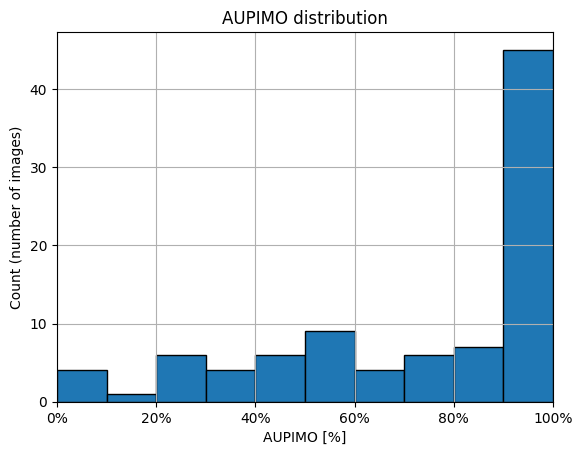

In [14]:
fig, ax = plt.subplots()
ax.hist(aupimo_result.aupimos.numpy(), bins=np.linspace(0, 1, 11), edgecolor="black")
ax.set_ylabel("Count (number of images)")
ax.yaxis.set_major_locator(MaxNLocator(5, integer=True))
ax.set_xlim(0, 1)
ax.set_xlabel("AUPIMO [%]")
ax.xaxis.set_major_formatter(PercentFormatter(1))
ax.grid()
ax.set_title("AUPIMO distribution")
fig  # noqa: B018, RUF100

# Cite Us

AUPIMO was developed during Google Summer of Code 2023 (GSoC 2023) with the `anomalib` team from OpenVINO Toolkit.

Our work was accepted to the British Machine Vision Conference 2024 (BMVC 2024).

```bibtex
@misc{bertoldo2024aupimo,
      title={{AUPIMO: Redefining Visual Anomaly Detection Benchmarks with High Speed and Low Tolerance}}, 
      author={Joao P. C. Bertoldo and Dick Ameln and Ashwin Vaidya and Samet Akçay},
      year={2024},
      eprint={2401.01984},
      archivePrefix={arXiv},
      primaryClass={cs.CV},
      url={https://arxiv.org/abs/2401.01984}, 
}
```

Paper on arXiv: [arxiv.org/abs/2401.01984](https://arxiv.org/abs/2401.01984) (accepted to BMVC 2024)

Medium post: [medium.com/p/c653ac30e802](https://medium.com/p/c653ac30e802)

Official repository: [github.com/jpcbertoldo/aupimo](https://github.com/jpcbertoldo/aupimo) (numpy-only API and numba-accelerated versions available)

GSoC 2023 page: [summerofcode.withgoogle.com/archive/2023/projects/SPMopugd](https://summerofcode.withgoogle.com/archive/2023/projects/SPMopugd)